In [ ]:
# Load the data from the Apporto machine to the Colab environment

from google.colab import files
uploaded = files.upload()

Saving Hotel Cancellation.csv to Hotel Cancellation.csv


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [ ]:
# Read data from a CSV file into a data frame
df = pd.read_csv('Hotel Cancellation.csv')

# Display the first ten rows of the data frame to examine if it is an individual-level data set
df.head(10)

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,origin_Portugal,reserved_standard_room,made_booking_changes,made_special_requests,come_alone,with_chilren,no_deposit,travel_agents/tour_operators_distributed,direct_distributed,online_purchased,arrival_peak_season,arrival_winter_season,has_previous_cancellations,city_hotel
0,0,2.227042,-0.928887,-1.310234,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0
1,0,5.923360,-0.928887,-1.310234,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0
2,0,-0.907810,-0.928887,-0.786204,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0
3,0,-0.851664,-0.928887,-0.786204,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
4,0,-0.842306,-0.928887,-0.262173,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0
5,0,-0.842306,-0.928887,-0.262173,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0
6,0,-0.973315,-0.928887,-0.262173,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0
7,0,-0.889095,-0.928887,-0.262173,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0
8,1,-0.177904,-0.928887,0.261857,0,1,1,0,1,0,0,1,1,0,1,1,0,0,0
9,1,-0.271482,-0.928887,0.261857,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0


In [ ]:
#Part 1: Data Partition:

from sklearn.model_selection import train_test_split

#Splitting the data into our partitions will return two dataframes, so we must prep like so:
testpart_size = .2
df_partition = df

df_nontestdata, df_testdata = train_test_split(df_partition, test_size = testpart_size, random_state = 1)

df_nontestdata

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,origin_Portugal,reserved_standard_room,made_booking_changes,made_special_requests,come_alone,with_chilren,no_deposit,travel_agents/tour_operators_distributed,direct_distributed,online_purchased,arrival_peak_season,arrival_winter_season,has_previous_cancellations,city_hotel
31386,0,0.486497,1.073890,0.261857,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0
1789,0,-0.187262,3.076667,3.930071,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0
685,1,-0.159189,1.073890,0.785888,0,1,1,0,1,0,0,1,1,0,1,1,0,0,0
77349,1,0.804661,0.072502,-0.786204,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1
7814,1,-0.898452,1.073890,-0.786204,0,1,1,0,0,0,0,1,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,1,0.355488,1.073890,0.261857,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
98047,0,-0.280840,-0.928887,-0.786204,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1
5192,1,-0.505426,1.073890,1.309918,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0
77708,0,-0.973315,-0.928887,-0.262173,0,1,1,0,1,1,0,1,1,0,1,0,0,0,1


In [ ]:
def profit_calculation(model, x_value, y_value):
  d_cutoff = 1/2

  decision = list(model.predict_proba(x_value)[:,1] < d_cutoff)   
  y = list(y_value)
  n_obs = len(y)
    
  cum_profit = 0

  for i in range(n_obs):
      if decision[i] == True and y[i] == 1: 
          profit = -2 
      elif decision[i] == True and y[i] == 0: 
          profit = 10 
      elif decision[i] == False and y[i] == 1: 
          profit = 0
      else:
          profit = 8 
      cum_profit = cum_profit + profit 

  average_net_profit = cum_profit / n_obs 
  return average_net_profit

In [ ]:
#Logistic Regression Analysis:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

DV = 'is_canceled'
y = df_nontestdata[DV]
X = df_nontestdata.drop(columns = [DV])

def summary_coef(model_object):
    n_predictors = X.shape[                                                                                                                                                                                                                                  1]
    model_coef = pd.DataFrame(model_object.coef_.reshape(1,n_predictors),columns = X.columns.values)
    model_coef['Intercept'] = model_object.intercept_
    return (model_coef.transpose())

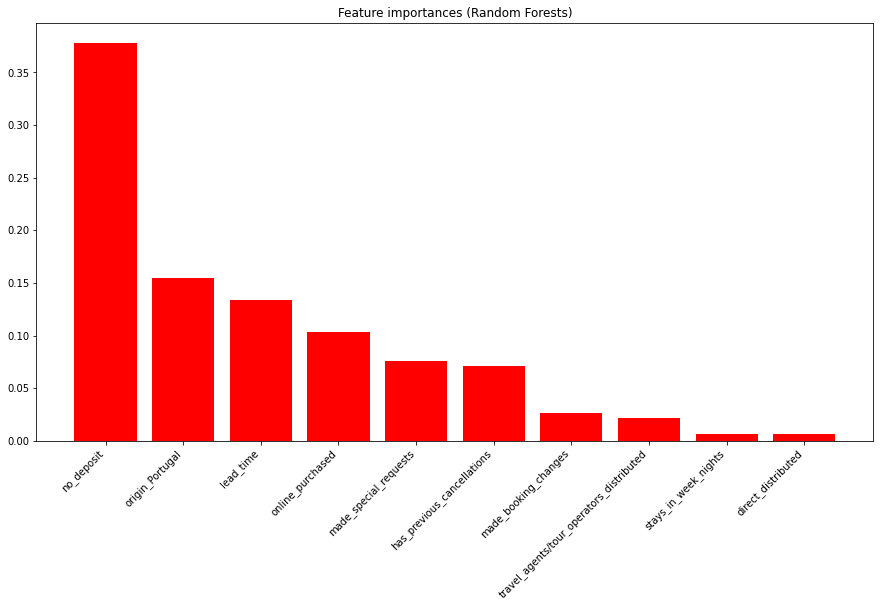

In [ ]:
# Random Forest Analysis that maximize roc_auc
strarifiedCV = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=0)
param_grid = dict( )
from sklearn.ensemble import RandomForestClassifier
clf_RFC =  GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6),
                        param_grid=param_grid, scoring='roc_auc', cv=strarifiedCV, n_jobs=-1).fit(X, y)

coefs_RFC = clf_RFC.best_estimator_.feature_importances_
indices = np.argsort(coefs_RFC)[::-1]


plt.figure(figsize=(15,10))
plt.title("Feature importances (Random Forests)")
plt.bar(range(10), coefs_RFC[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)


In [ ]:
#Predicted values of the DV in the test partition

#Actual values of the DV in the test partition
y_test_actual = df_testdata[DV]

#Predictor values in the test_partition
X_test = df_testdata.drop(columns = [DV])

y_test_predicted = clf_RFC.predict(X_test)

n_obs_test = df_testdata.shape[0]

from sklearn import metrics
print(metrics.confusion_matrix(y_test_actual, y_test_predicted))

clf_RFC.score(X_test,y_test_actual)

[[14057  1044]
 [ 3323  5454]]


0.8901145714559978

In [ ]:
print(roc_auc_score(y_test_actual, clf_RFC.predict_proba(X_test)[:,1]))

0.8901145714559978


In [ ]:
# Random Forest Analysis that maximize average net
clf_RF_profit = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6),
                        param_grid=param_grid, scoring=profit_calculation, cv=strarifiedCV, n_jobs=-1).fit(X, y)


#print the average net profit
print(profit_calculation(clf_RF_profit, X, y))

5.918669905352207
